# Hanghzou Irmin Pack File Analysis

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import custom_plot_tools

This document presents statistics computed on a pack file which results from a Tezos bootstrapping on the first 2 month of the Hanghzou protocol.

The goal of this document is to gather insights for future improvements of irmin-pack, notably for the layered store design.

## Contents of this Work

```
pack file -> OCaml program -> csv files -> notebook generator programs -> notebooks
```

An OCaml program scans the pack file, gathering data that are saved to csv files that can be found in the `csv` directory in the same repository.

For the occasion, was written a pack file tree traversal algorithm ([traverse.ml](./traverse.ml)) that reads the disk pages only once while traversing from high offsets to low offsets. This algorithm can be used to fold over the entries and also to fold over the chunks of consecutive entries (for optimised copies).

The csv results are analysed throughout ipython notebooks (like this one) which are generated using the `gen_*.py` scripts in the same repository.

The results are splitted on several pages 📄.

The light bulbs 💡 accompanying the data are insights on what can be seen.

## Definition: _Tree of a Commit_

In Irmin, a commit points to a root directory (i.e. the "/" path), which itself references files and/or sub-directories. Directories are called _nodes_ and files are called _contents_ or _blobs_. Both are _objects_ in Irmin. The root node and all the objects reachable from it constitute the _tree of a commit_.

When the tree of a commit is fully loaded from disk to memory to a `Tree.t` value, it really is a _tree_ in the graph sense. However, when looking at the tree of a commit on-disk in irmin-pack, it is stored as a DAG.

In memory objects that correspond to a common backend object have the same _key_. For irmin-pack, it means having the same _offset_ in the pack file, since the key stores the offset.

Subtrees that have the same key also have the same hash, but the opposite is not true. When irmin-pack's indexing strategy is _always,_ there is a bijection between the keys and hashes of persisted objects. When the strategy is _minimal,_ there is no such bijection because the hash-consing using _Index_ is disabled, resulting in duplication in the pack file.

Since this document focuses on what's stored on disk in irmin-pack, key-equality is used over hash-equality to reason about object equality. "an object" can then be interpreted as "an offset on disk". Concretely:
- if an object appears at 2 paths, it means that it's key is referenced twice;
- if a subtree appears multiple time at different paths, it is counted only once in the stats;
- the on-disk size of a tree counts the bytes only once without attempting any kind of unrolling.

Regardless of the indexing strategy, in Tezos, the tree of a commit shares more than 99.9% of its disk space with the tree of the preceeding commit. This is happening because in lib_context, the tree of the newer commit was formed by modifying the in-memory tree of the older commit, and that Irmin's `Tree` module is conservative when persisting a tree to backend.

Regardless of the indexing strategy, in Tezos, many contents and nodes appear several time in the tree. This is happening because Tezos tend to copy nodes and contents around, instead of re-creating them from scratch.


## Contents of the Pack File

This bootstraping was realised using Irmin 3.0 and its new structured keys using the _minimal_ indexing strategy, which results in a bit less sharing in the pack file.

Ignoring the genesis commit which is present in all Tezos pack files, the first commit of the pack file belongs to block 1,916,930 (2nd of Hangzhou, 2nd of cycle 428, 4 Dec 2021, https://tzstats.com/1916930). This commit was created by a Tezos snapshot import.

The last commit analysed belongs to block 2,056,194 (2nd of cycle 445, 23 Jan 2022, https://tzstats.com/2056194). This commit is analysed in depth in the __The Tree of Commit 445__ section.


#### Summary
```
Number of objects: 236,852,348 (a.k.a. pack file entries). Breakdown:
-  25%  59,891,667 contents (a.k.a. blobs);
-  26%  60,459,864 nodes (a.k.a. root inodes, directories);
-  49% 116,361,386 hidden nodes (a.k.a. non-root inodes);
-   0%     139,431 commits.

Number of bytes: 54,883,310,261. First breakdown:
-  16%  8,772,660,562B in contents;
-  14%  7,936,622,987B in nodes;
-  70% 38,158,643,814B in hidden nodes;
-   0%     15,382,898B in commits.

Second breakdown:
-  14%  7,579,275,136B used by the 32 byte hash that prefixes all objects;
-  86% 47,304,035,125B elsewhere.
```

💡 The hidden nodes are responsible for 70% of the size of the pack file.

💡 `139,431` commits are accounted above, but when looking at the block levels we would expect `139,265` (`2,056,194 - 1,916,930 + 1`). This difference is due to orphan blocks.

## Pack File Areas

This document focuses on 18 commits, which are the 2nd of the Tezos cycles 428 to 445. "Commit 428" is the first commit of the pack file (ignoring the genesis commit) and "commit 445" is the last commit analysed in this document.

This document considers 19 areas delimited by the 18 commits. An area X contains the data that was pushed to the pack file during the cycle X.



|idx|area|first commit level|blob count|node count|hidden node count|commit count|object count|bytes|offset interval|
|-|-|-|-|-|-|-|-|-|-|
| 0 | 427 | ø | 6,328,541 | 5,119,464 | 3,241,347 | 1 | 14,689,353 | 1,832,606,549 | `[0; 1,832,606,549[` |
| 1 | 428 | 1,916,930 | 3,046,551 | 3,162,215 | 6,070,742 | 8,203 | 12,287,711 | 2,879,163,495 | `[1,832,606,549; 4,711,770,044[` |
| 2 | 429 | 1,925,122 | 3,175,351 | 3,279,818 | 6,488,669 | 8,203 | 12,952,041 | 3,050,904,905 | `[4,711,770,044; 7,762,674,949[` |
| 3 | 430 | 1,933,314 | 2,817,587 | 2,934,098 | 5,526,412 | 8,201 | 11,286,298 | 2,644,854,286 | `[7,762,674,949; 10,407,529,235[` |
| 4 | 431 | 1,941,506 | 3,049,830 | 3,159,645 | 6,205,091 | 8,204 | 12,422,770 | 2,900,259,276 | `[10,407,529,235; 13,307,788,511[` |
| 5 | 432 | 1,949,698 | 3,084,785 | 3,191,324 | 6,307,162 | 8,201 | 12,591,472 | 2,938,385,399 | `[13,307,788,511; 16,246,173,910[` |
| 6 | 433 | 1,957,890 | 3,172,425 | 3,246,952 | 6,599,074 | 8,202 | 13,026,653 | 3,107,269,214 | `[16,246,173,910; 19,353,443,124[` |
| 7 | 434 | 1,966,082 | 3,015,265 | 3,098,783 | 6,242,396 | 8,200 | 12,364,644 | 2,945,593,593 | `[19,353,443,124; 22,299,036,717[` |
| 8 | 435 | 1,974,274 | 3,179,567 | 3,241,328 | 6,659,913 | 8,203 | 13,089,011 | 3,156,334,378 | `[22,299,036,717; 25,455,371,095[` |
| 9 | 436 | 1,982,466 | 3,239,028 | 3,295,772 | 6,791,154 | 8,201 | 13,334,155 | 3,198,100,177 | `[25,455,371,095; 28,653,471,272[` |
| 10 | 437 | 1,990,658 | 3,014,219 | 3,112,545 | 6,107,953 | 8,202 | 12,242,919 | 2,912,636,504 | `[28,653,471,272; 31,566,107,776[` |
| 11 | 438 | 1,998,850 | 3,300,403 | 3,378,911 | 6,955,529 | 8,200 | 13,643,043 | 3,305,566,570 | `[31,566,107,776; 34,871,674,346[` |
| 12 | 439 | 2,007,042 | 3,233,702 | 3,335,942 | 6,993,303 | 8,201 | 13,571,148 | 3,326,159,993 | `[34,871,674,346; 38,197,834,339[` |
| 13 | 440 | 2,015,234 | 3,265,901 | 3,381,789 | 7,150,187 | 8,201 | 13,806,078 | 3,391,789,883 | `[38,197,834,339; 41,589,624,222[` |
| 14 | 441 | 2,023,426 | 3,397,525 | 3,527,851 | 7,482,149 | 8,201 | 14,415,726 | 3,474,777,339 | `[41,589,624,222; 45,064,401,561[` |
| 15 | 442 | 2,031,618 | 3,097,995 | 3,251,901 | 6,890,066 | 8,204 | 13,248,166 | 3,159,189,881 | `[45,064,401,561; 48,223,591,442[` |
| 16 | 443 | 2,039,810 | 3,333,561 | 3,424,060 | 7,687,013 | 8,198 | 14,452,832 | 3,510,234,857 | `[48,223,591,442; 51,733,826,299[` |
| 17 | 444 | 2,048,002 | 3,139,431 | 3,317,466 | 6,963,226 | 8,204 | 13,428,327 | 3,149,483,852 | `[51,733,826,299; 54,883,310,151[` |
| 18 | 445 | 2,056,194 | 0 | 0 | 0 | 1 | 1 | 110 | `[54,883,310,151; 54,883,310,261[` |

💡 The first area starts at the beginning of the pack file and ends right before commit 428.

💡 The second area's first object is commit 428. This area ends right before commit 429.

💡 The first area contains the genesis commit. The last area only contains commit 445. All other areas have at least 8192 commits, which is the number of block level in a cycle, the other commits being orphan ones.

💡 The first area is solely made of objects from the snapshot import.

💡 Aside for ~7 objects that belong to the genesis commit, the objects of the first area are the objects of the tree of commit 428.


#### Areas Evolution
It can be seen in the above table that the areas get bigger over time. This is because the Tezos blockchain is growing. Recent cycles tend to host more transactions than the older ones.


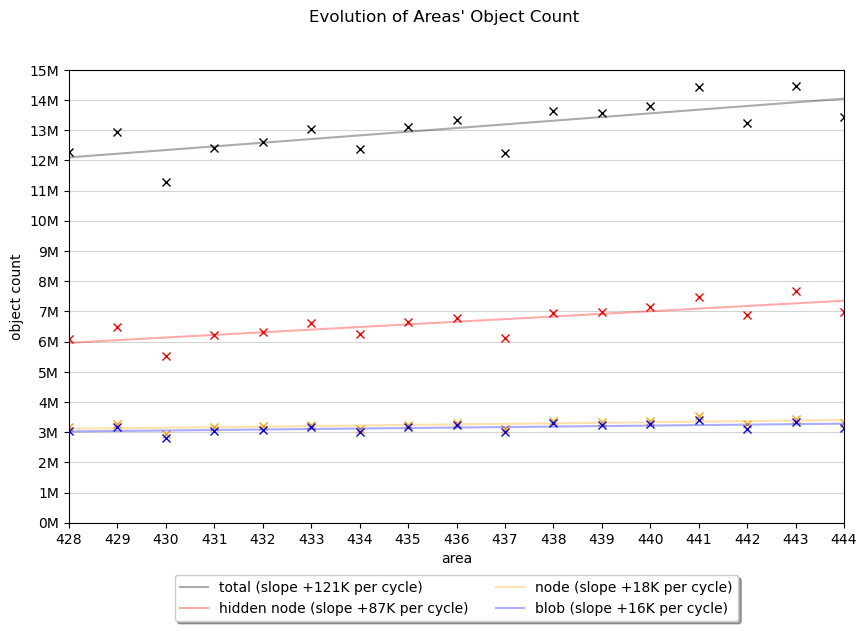

In [2]:
custom_plot_tools.plot_area_curve_object_count('/tmp/summary_df1.csv', 'area', "Evolution of Areas' Object Count", xbounds=(428, 444))

💡 Cycles 430, 434, 437, 442 and 444 are significantly below the average curve. They correspond to week-ends and holidays!


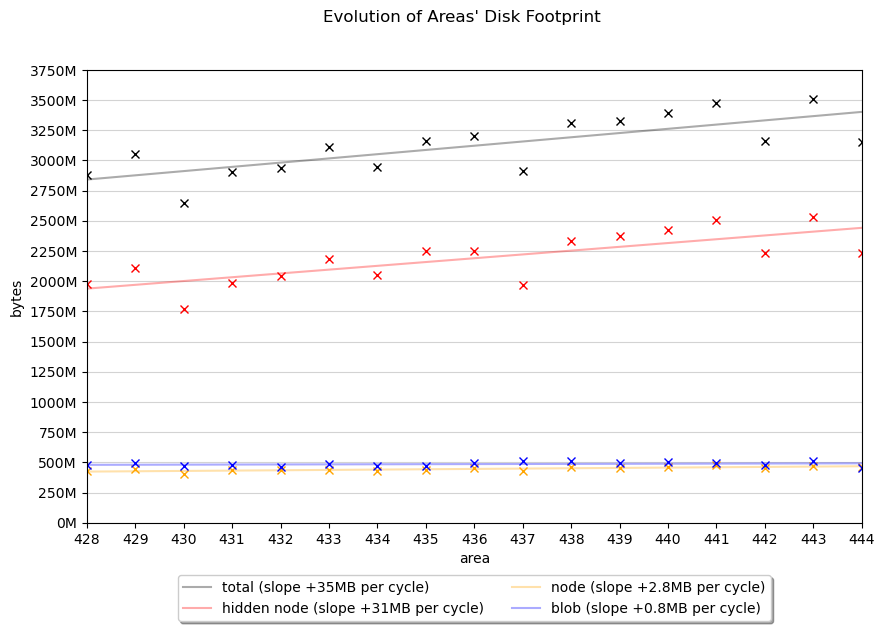

In [3]:
custom_plot_tools.plot_area_curve_byte_count('/tmp/summary_df1.csv', 'area', "Evolution of Areas' Disk Footprint", xbounds=(428, 444))

💡 Each area weigh around 3GB, which corresponds the growth of the pack file at every cycle (every 3 days).

💡 Every cycle the pack file write rate increases by ~1% (35MB over 3000MB).

💡 Cycle 428 grew the pack file by ~2.9GB and cycle 443 by ~3.5GB. Most of this acceleration is due to the hidden nodes.


## Tree of Commits

The previous section focused on the everything that was pushed to the pack file during cycles. This new section focuses on how the trees evolve. The pack file getting big is a short term problem for rolling Tezos nodes, but the commit tree getting big is a long term problem. Fortunately, the commit tree grows much slower than the pack file.


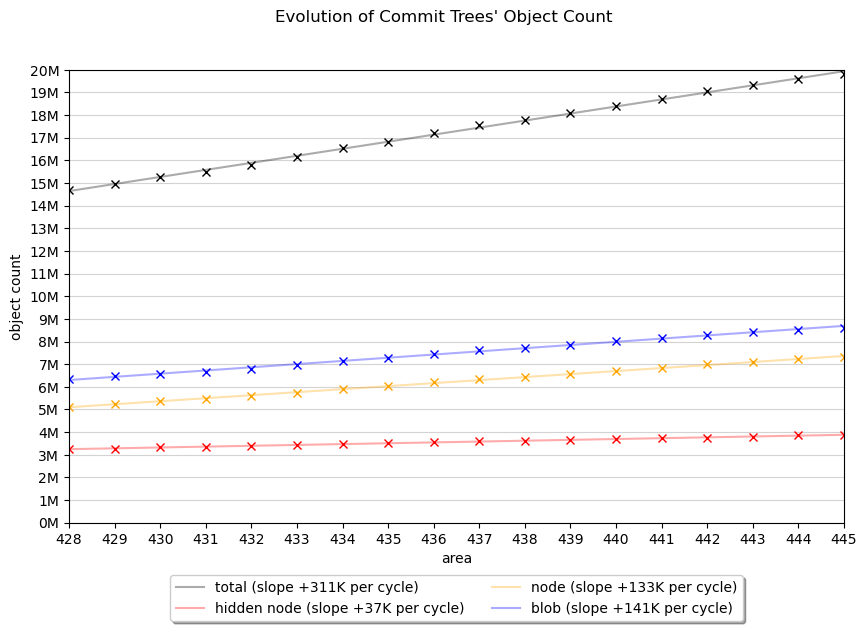

In [4]:
custom_plot_tools.plot_area_curve_object_count('/tmp/all_trees_df1.csv', 'parent_cycle_start', "Evolution of Commit Trees' Object Count")

💡 While the rate at which the pack file areas grows is unstable, the rate at which the commit trees grows is very stable.

💡 The previous section shows that ~6 million hidden nodes are pushed per cycle. The above plot shows that the commit tree gains 37K hidden nodes every cycle. This means that ~0.5% of the hidden nodes stick around in the tree durably.

💡 The previous section shows that ~3 million blobs are pushed per cycle. The above plot shows that the commit tree gains 141K blobs every cycle. This means that ~5% of the blobs stick around in the tree durably.


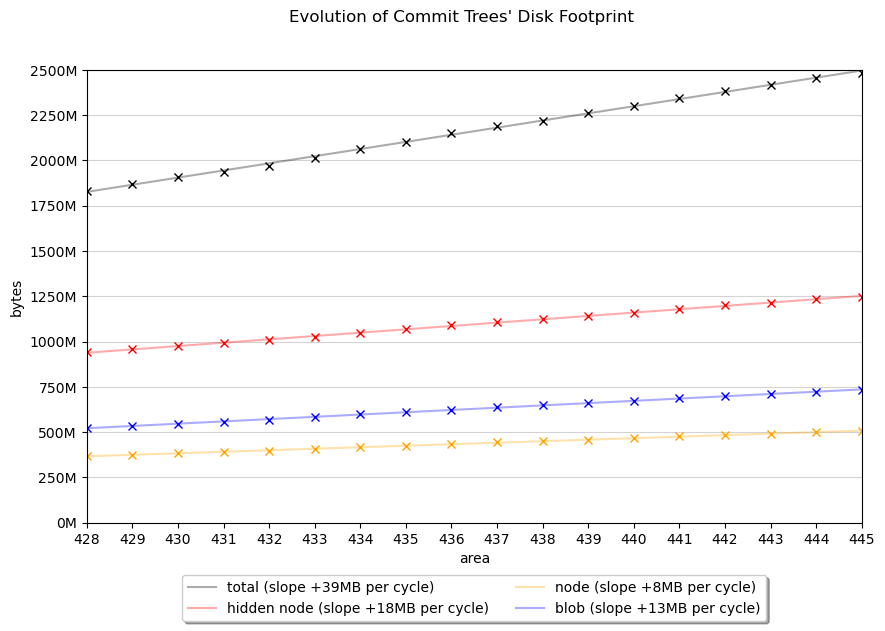

In [5]:
custom_plot_tools.plot_area_curve_byte_count('/tmp/all_trees_df1.csv', 'parent_cycle_start', "Evolution of Commit Trees' Disk Footprint")

💡 The commit tree weighs ~2.5GB at the end of Jan 2022. The commit tree growth rate is 39MB per cycle, which extrapolates to 5GB per year.

💡 The commit tree grows 39MB per cycle while the pack file grows 3GB per cycle. These numbers don't reflect the fact that a cycle replaces objects from previous cycles. The data in __The Tree of Commit 445__ shows that commit 445 references 267MB of data from cycle 444 and 154MB from cycle 443.


## Areas and Trees Cross-Analysis

[📄areas_and_trees.ipynb](./areas_and_trees.ipynb) details where the data of each tree is located in the pack file.



## The Tree of Commit 445

The stats in this section focus on the tree at the beginning of cycle 445. Many more objects were added during cycle 444 and all the previous cycles, but only a fraction is still referenced by the tree at the beginning of cycle 445.

[📄tree_of_cycle_445.ipynb](./tree_of_cycle_445.ipynb) details the contents of the tree.

These notebooks zoom on the heaviest paths of the tree:
- `/data/contracts/index`, the largest node in the tree [📄url](./tree_of_cycle_445_contracts-index.ipynb);
- `/data/contracts/index/*`, the children of the largest node [📄url](./tree_of_cycle_445_contracts-index-star.ipynb);
- `/data/contracts/index/*/manager`, a contents present in almost all contracts [📄url](./tree_of_cycle_445_contracts-index-star-manager.ipynb);
- `/data/big_maps/index/*/contents` is where 43% of the bytes of the tree are located [📄url](./tree_of_cycle_445_big_maps-index-star-contents.ipynb);
- `/data/big_maps/index/*/contents/*` are 5 million small nodes [📄url](./tree_of_cycle_445_big_maps-index-star-contents-star.ipynb);
- `/data/big_maps/index/*/contents/*/data` are contents that take up a lot of space [📄url](./tree_of_cycle_445_big_maps-index-star-contents-star-data.ipynb).



## Conclusion

There is room for improvements with the on-disk encoding of irmin-pack and the layered store garbage collection will solve the pack file growth. However, the extrapolated commit tree growth is massive: x3 over a year. At best we can lower the on-disk size by constant factors. The layered store is helpless regarding growths in the size of the tree. Tripling the size of the tree implies tripling the size of the "sparse pack file" of the layered store. This might also mean tripling the length of the freezes.

Nothing suggests that Irmin trees, irmin-pack and the layered store will not support that projected load, but we need to think about the implications of this and proactively ensure that things will be OK.

It is unexpected to see that so much bytes are occupied by "direct" steps (40% in the commit tree). The way the dict behaves is obviously sub-optimal (i.e. when full it stops ingesting new data). 3 ideas for improvements:
- Manually push the ~150 recurring steps (i.e. the english words like "delegated") to the dict and see if it has a positive impact. This might improve the situation for `/data/contracts/index/*`.
- Introduce a "step_key", analoguous to the structured keys, which would allow to have steps not just being "indirect" and "direct" but also offsets that point to "direct" steps earlier in the pack file.
- Some steps are known to be human-readable ascii integers (i.e. 35 bytes in `/data/contracts/index` and 65 bytes in `/data/big_maps/index/*/contents`). Tezos could migrate the tree to use a binary form for these steps, or a feature could be added to Irmin that would allow that optimisation at serialisation time.

